In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = ("/content/gdrive/MyDrive/BrainStroke/Brain_Stroke_CT-SCAN_image/Train")

test_dir = ("/content/gdrive/MyDrive/BrainStroke/Brain_Stroke_CT-SCAN_image/Test")

validation_dir = ("/content/gdrive/MyDrive/BrainStroke/Brain_Stroke_CT-SCAN_image/Validation")

In [ ]:
img_width, img_height = 256, 256

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

Found 1843 images belonging to 2 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

Found 235 images belonging to 2 classes.


In [ ]:
# Load pre-trained ResNet152 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
    )

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
58/58 [==============================] - 1497s 26s/step - loss: 0.6756 - accuracy: 0.5773 - val_loss: 0.6204 - val_accuracy: 0.6681
Epoch 2/10
58/58 [==============================] - 1472s 25s/step - loss: 0.6579 - accuracy: 0.6099 - val_loss: 0.6382 - val_accuracy: 0.6894
Epoch 3/10
58/58 [==============================] - 1473s 25s/step - loss: 0.6442 - accuracy: 0.6305 - val_loss: 0.5908 - val_accuracy: 0.6809
Epoch 4/10
58/58 [==============================] - 1463s 25s/step - loss: 0.6160 - accuracy: 0.6663 - val_loss: 0.6131 - val_accuracy: 0.6766
Epoch 5/10
58/58 [==============================] - 1484s 26s/step - loss: 0.5818 - accuracy: 0.6907 - val_loss: 0.5871 - val_accuracy: 0.7064
Epoch 6/10
58/58 [==============================] - 1456s 25s/step - loss: 0.5817 - accuracy: 0.6945 - val_loss: 0.5301 - val_accuracy: 0.7447
Epoch 7/10
58/58 [==============================] - 1457s 25s/step - loss: 0.5376 - accuracy: 0.7292 - val_loss: 0.5814 - val_accuracy: 0.6723

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

14/14 [==============================] - 334s 23s/step - loss: 0.4592 - accuracy: 0.7826
Test Loss: 0.4591868817806244
Test Accuracy: 0.782608687877655


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def Affected_Area(img_path):

        image = cv2.imread(img_path)
       # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply image processing operations (e.g., thresholding, morphological operations) for stroke detection
        _, thresholded_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)

        # Find contours in the closed image
        contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a list to store the bounding boxes
        bounding_boxes = []

        # Draw bounding boxes around the contours
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, x + w, y + h))
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        return image


target_class_index = 1
img_path = '/content/gdrive/MyDrive/BrainStroke/Brain_Stroke_CT-SCAN_image/Test/Stroke/58 (12).jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (img_width, img_height))
img = np.expand_dims(img, axis=0) / 255.0
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer('conv2d_1').output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img)
    loss = predictions[:, 0]  # Select the first (and only) element along the second dimension

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


superimposed_img = cv2.addWeighted(
    np.uint8(255 * img[0]),
    0.6,
    np.uint8(heatmap),
    0.4,
    0
)


plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.title('Original Image')
plt.axis('off')

predicted_class = model.predict(img)
predicted_class_index = int(predicted_class[0] >= 0.5)  # Get the index of the predicted class
class_names = ['No Stroke', 'Stroke']  # Define the class names
print('Class',predicted_class_index)


if predicted_class_index == 1:
    plt.subplot(1, 4, 2)
    plt.imshow(superimposed_img)
    plt.title(f'Predicted Class: {class_names[predicted_class_index]}')  # Use the predicted class index to get the class name
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    Stroke_Affected = Affected_Area(img_path)

    plt.subplot(1, 4, 4)
    plt.imshow(Stroke_Affected)
    plt.title('Affected Part')
    plt.axis('off')


    plt.tight_layout()
    plt.show()
else:
    plt.subplot(1, 4, 2)
    plt.imshow(img[0])
    plt.title(f'Predicted Class: {class_names[predicted_class_index]}')
    plt.axis('off')

ValueError: No such layer: conv2d_1. Existing layers are: ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'global_average_pooling2d', 'dense', 'dense_1', 'dense_2'].

Found 437 images belonging to 2 classes.
14/14 [==============================] - 300s 21s/step


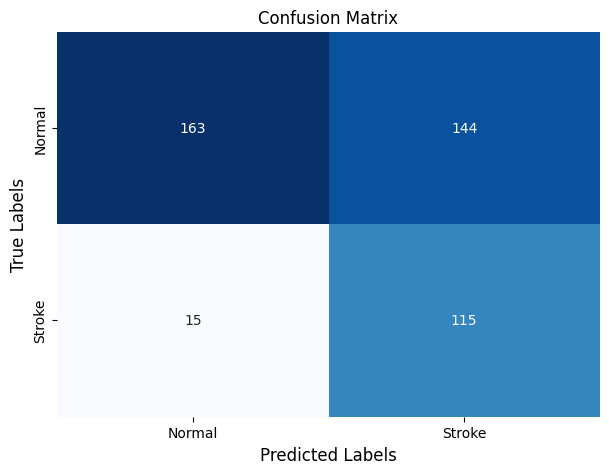

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Rest of the code...

# Step 4: Model Evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)



# Plot confusion matrix
label_names = ['Normal', 'Stroke']  # Replace with your class labels
beingsaved = plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(np.arange(len(label_names)) + 0.5, label_names)
plt.yticks(np.arange(len(label_names)) + 0.5, label_names)
plt.xlabel('Predicted Labels',fontsize=12)
plt.ylabel('True Labels',fontsize=12)
plt.title('Confusion Matrix')
beingsaved.savefig('Stroke_Confusion_Matrix.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def Affected_Area(img_path):

    image = cv2.imread(img_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply image processing operations (e.g., thresholding, morphological operations) for stroke detection
    _, thresholded_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a list to store the bounding boxes
    bounding_boxes = []

    # Draw bounding boxes around the contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x + w, y + h))
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return image


target_class_index = 1
img_path = '/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Test/Stroke/58 (12).jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (img_width, img_height))
img = np.expand_dims(img, axis=0) / 255.0
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer('conv2d_1').output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img)
    loss = predictions[:, 0]  # Select the first (and only) element along the second dimension

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heatmap = np.max(heatmap)
if max_heatmap != 0:
    heatmap /= max_heatmap
heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(
    np.uint8(255 * img[0]),
    0.6,
    np.uint8(heatmap),
    0.4,
    0
)


plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.title('Original Image')
plt.axis('off')

predicted_class = model.predict(img)
predicted_class_index = int(predicted_class[0] >= 0.5)  # Get the index of the predicted class
class_names = ['No Stroke', 'Stroke']  # Define the class names
print('Class', predicted_class_index)

if predicted_class_index == 1:
    plt.subplot(1, 4, 2)
    plt.imshow(superimposed_img)
    plt.title(f'Predicted Class: {class_names[predicted_class_index]}')  # Use the predicted class index to get the class name
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    Stroke_Affected = Affected_Area(img_path)

    plt.subplot(1, 4, 4)
    plt.imshow(Stroke_Affected)
    plt.title('Affected Part')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    plt.subplot(1, 4, 2)
    plt.imshow(img[0])
    plt.title(f'Predicted Class: {class_names[predicted_class_index]}')
    plt.axis('off')

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def Affected_Area(img_path):
    image = cv2.imread(img_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply image processing operations (e.g., thresholding, morphological operations) for stroke detection
    _, thresholded_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a list to store the bounding boxes
    bounding_boxes = []

    # Draw bounding boxes around the contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x + w, y + h))
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return image

target_class_index = 1
img_path = '/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Test/Stroke/58 (12).jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (img_width, img_height))
img = np.expand_dims(img, axis=0) / 255.0

grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer('conv2d').output, model.output]  # Modify 'conv2d_1' to match the actual layer name
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img)
    loss = predictions[:, 0]  # Select the first (and only) element along the second dimension

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(
    np.uint8(255 * img[0]),
    0.6,
    np.uint8(heatmap),
    0.4,
    0
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.title('Original Image')
plt.axis('off')

predicted_class = model.predict(img)
predicted_class_index = int(predicted_class[0] >= 0.5)  # Get the index of the predicted class
class_names = ['No Stroke', 'Stroke']  # Define the class names

if predicted_class_index == 1:
    plt.subplot(1, 4, 2)
    plt.imshow(superimposed_img)
    plt.title(f'Predicted Class: {class_names[predicted_class_index]}')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    Stroke_Affected = Affected_Area(img_path)

    plt.subplot(1, 4, 4)
    plt.imshow(Stroke_Affected)
    plt.title('Affected Area')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    plt.subplot(1, 4, 2)
    plt.imshow(img[0])
    plt.title(f'Predicted Class: {class_names[predicted_class_index]}')
    plt.axis('off')